In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from datetime import datetime
from datetime import timedelta
import matplotlib.cm as cm
import scipy

# setting things up:

In [3]:
path = Path.cwd()
forcing_path = path / "Forcing"
observations_path = path / "Observations"
output_path = path / "Output"
paths = forcing_path, output_path, observations_path
figure_path = path / "Figures"

In [4]:
units= {"Imax":"mm",
        "Ce": "-",
        "Sumax": "mm",
        "Beta": "-",
        "Pmax": "mm",
        "Tlag": "d",
        "Kf": "-",
        "Ks": "-",
        "FM":'mm/d/degC',
        "Si": "mm",
        "Su": "mm",
        "Sf": "mm",
        "Ss": "mm",
        "Sp": "mm",
        "Ei_dt": "mm/d",
        "Ea_dt": "mm/d",
        "Qs_dt": "mm/d",
        "Qf_dt": "mm/d",
        "Q_tot_dt": "mm/d",
        "Q": "mm/d"}

p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
names = p_names + S_names
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]

var_names =  {x: names[i] for i, x in enumerate(param_names + stor_names)}

In [5]:
def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qo - Qm)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)
    
def calc_log_NSE(Qo, Qm):
    Qo[Qo == 0] = 1e-6
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((np.log(Qo) - np.log(Qm))**2)
    ErrDo = np.sum((np.log(Qo) - np.log(QoAv))**2)
    return 1 - (ErrUp / ErrDo)

In [6]:
def plot_hydrograph(ds_combined, ax):
    NSE_mean = calc_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat="mean").values)
    NSE_mean_log = calc_log_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat="mean").values)
    
    ds_combined["Q_obs"].plot(ax=ax,lw=0,marker="*",ms=2.0,zorder=0,label="Observations",color='k')
    
    ds_combined["Q"].sel(summary_stat="mean").plot(ax=ax, color="C1",lw=0.5,label=f"mean NSE: {NSE_mean:.2f}\n   Log NSE: {NSE_mean_log:.2f}",zorder=-1)
    
    ax.fill_between(ds_combined.time, 
                             ds_combined["Q"].sel(summary_stat="min").values,
                             ds_combined["Q"].sel(summary_stat="max").values,color="C0", alpha=0.35,zorder=-10,label="bounds")
    n_particles = ds_combined.attrs['n_particles']
    ax.set_ylabel("Q [mm]")
    ax.set_title(f"Run ensemble of {n_particles} particles");
    return ax

In [7]:
def plot_variable(ds_combined, variable, axs):    
    axs[0] = plot_hydrograph(ds_combined, axs[0])
    n_particles = ds_combined.attrs['n_particles']
    
    for i, var in enumerate(variable):
        axs[i+1].fill_between(ds_combined.time, 
                         ds_combined[var].sel(summary_stat="min").values,
                         ds_combined[var].sel(summary_stat="max").values, color=f"C{i}",alpha=0.75, zorder=-10)
        
        ds_combined[var].sel(summary_stat="mean").plot(ax=axs[i+1], color="k",lw=0.9,zorder=-1,alpha=0.3,label="mean")
        axs[i+1].set_title(var_names[var])
        axs[i+1].set_ylabel(f'{var} [{units[var]}]')
        if i == 0:
            axs[i+1].legend()
    return axs

In [8]:
def plot_params(ds_combined, params, ax, regress=False):
    for j, parameter in enumerate(params):
        ax = axs[j]
        n_particles = ds_combined.attrs['n_particles']
        ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="k", label="mean")
        ax.fill_between(ds_combined.time, 
                         ds_combined[parameter].sel(summary_stat="min").values,
                         ds_combined[parameter].sel(summary_stat="max").values,alpha=0.75, color=f"C{j}")
        ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
        ax.set_ylabel(f'[{units[param_names[j]]}]')
        if j == 0: 
            ax.legend()

        if regress:
            x = range(len(ds_combined.time))
            result = scipy.stats.linregress(x, ds_combined[parameter].sel(summary_stat='mean').to_numpy())
            y = result.slope * x + result.intercept
            ax.plot(ds_combined.time, y, color="w",label=f"R$^2$={result.rvalue**2:.2f}")
            slope_text = '$m_{std}=$'
            ax.legend(title=f'{slope_text}{result.slope*365/y.mean():.4f}')

# Loading files

In [9]:
from pathlib import PosixPath

import paths from 39.2

In [10]:
paths = [PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01022500_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-17 14_02.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01013500_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-17 12_47.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01073000_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-18 00_07.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01162500_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-18 12_45.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01078000_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-18 01_23.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01031500_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-17 16_33.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01142500_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-18 10_13.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01057000_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-17 22_51.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01144000_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-18 11_29.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01118300_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-18 02_38.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01139000_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-18 07_42.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01139800_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-18 08_58.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01170100_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-18 15_16.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01047000_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-17 17_49.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01134500_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-17 11_31.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01169000_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-18 14_01.nc'),
 PosixPath('/media/davidhaasnoot/files/work/Studie TUD/Msc/Year 6/Q3 Thesis/Code/eWaterCycle-WSL-WIP/nbs_39_formalise_algorithm/Output/w2|5_s1e-2|1e-5/01181000_psf-0.001_pp-0_ps-0_w-2_N-500_2024-05-18 16_32.nc')]

In [11]:
from shutil import copyfile

In [12]:
# for i in range(len(paths)):
#     copyfile(paths[i], paths[i].parent.parent.parent.parent / 'nbs_40_run_all_camels' / 'Output' / paths[i].name)

In [13]:
lst_ds = []
for path in paths:
    ds = xr.open_dataset(path)
    lst_ds.append(ds)

In [14]:
lst_ds[0]

<xarray.Dataset> Size: 728kB
Dimensions:       (summary_stat: 3, time: 1857)
Coordinates:
  * summary_stat  (summary_stat) <U4 48B 'min' 'max' 'mean'
  * time          (time) datetime64[ns] 15kB 1997-08-01 ... 2002-08-31
Data variables: (12/18)
    Imax          (summary_stat, time) float64 45kB ...
    Ce            (summary_stat, time) float64 45kB ...
    Sumax         (summary_stat, time) float64 45kB ...
    Beta          (summary_stat, time) float64 45kB ...
    Pmax          (summary_stat, time) float64 45kB ...
    Tlag          (summary_stat, time) float64 45kB ...
    ...            ...
    Ss            (summary_stat, time) float64 45kB ...
    Sp            (summary_stat, time) float64 45kB ...
    Q             (summary_stat, time) float64 45kB ...
    Q_obs         (time) float64 15kB ...
    Neff          (time) float64 15kB ...
    n_resample    (time) float64 15kB ...
Attributes: (12/13)
    title:              HBV storage & parameter terms data over time for 500 ...
    history:            Storage term results from ewatercycle_HBV.model
    sigma_pp:           0
    sigma_ps:           0
    sigma_w:            2
    sigma_p_Sf:         0.001
    ...                 ...
    n_particles:        500
    HRU_id:             01022500
    p_min_initial:      [1.12182327e+00 3.22232898e-01 1.13079965e+02 1.37713...
    p_max_initial:      [3.20383033e+00 6.15753470e-01 3.05794566e+02 3.21596...
    s_max_initial:      [  2.55532786 167.43273213  42.05499716  32.14507687 ...
    s_min_initial:      [ 0.73914092 62.34886481 17.85686147 12.90167866 39.0...

In [17]:
df_r2 = pd.DataFrame(columns=param_names + stor_names)
df_m_std = pd.DataFrame(columns=param_names + stor_names)
df_c = pd.DataFrame(columns=param_names + stor_names)
for ds_combined in lst_ds:
    HRU_id = ds_combined.attrs['HRU_id']
    x = range(len(ds_combined.time))
    for j, parameter in enumerate(param_names):
        result = scipy.stats.linregress(x, ds_combined[parameter].sel(summary_stat='mean').to_numpy())
        y = result.slope * x + result.intercept
        m_std = result.slope*365/y.mean() 
        df_r2.loc[HRU_id, parameter] = result.rvalue**2
        df_m_std.loc[HRU_id, parameter] = m_std
        df_c.loc[HRU_id, parameter] = result.intercept

    for i, stor in enumerate(stor_names):
        range_stores = ds_combined[stor].sel(summary_stat="max").to_numpy() - ds_combined[stor].sel(summary_stat="min").to_numpy()
        result = scipy.stats.linregress(x, range_stores)
        y = result.slope * x + result.intercept
        m_std = result.slope*365/y.mean() 
        df_r2.loc[HRU_id, stor] = result.rvalue**2
        df_m_std.loc[HRU_id, stor] = m_std
        df_c.loc[HRU_id, stor] = result.intercept

Text(0.5, 0.98, 'Standardized slopes for 17 catchments')

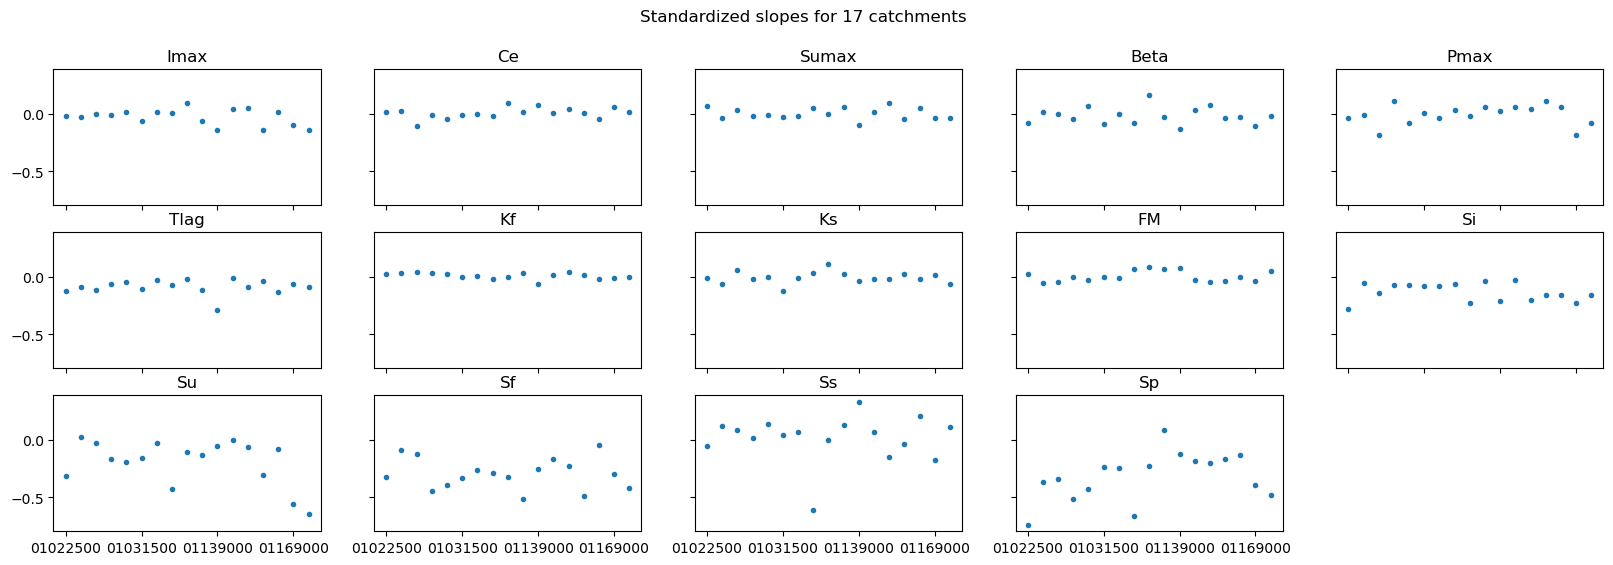

In [18]:
fig, ax = plt.subplots(3,5, figsize=(20,6), sharey=True, sharex=True)
ax = ax.flatten()
for i, col in enumerate(df_r2.columns): 
    df_m_std[[col]].plot(ax=ax[i],legend=None,marker=".",lw=0)
    ax[i].set_title(col)
    
ax[-1].axis('off');
fig.suptitle("Standardized slopes for 17 catchments")

Text(0.5, 0.98, 'coefficient of determination $R^2$ for for 17 catchments')

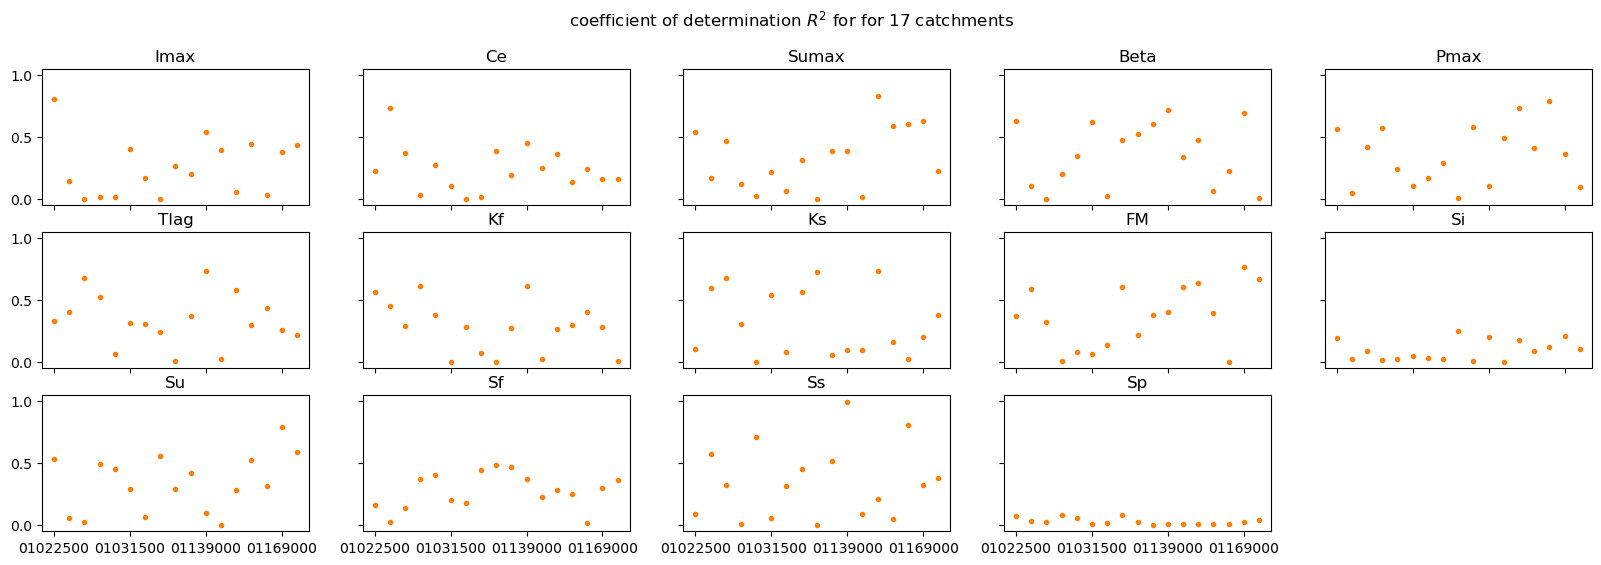

In [19]:
fig, ax = plt.subplots(3,5, figsize=(20,6), sharey=True, sharex=True)
ax = ax.flatten()
for i, col in enumerate(df_r2.columns): 
    df_r2[[col]].plot(ax=ax[i],legend=None,marker=".",lw=0,color="C1")
    ax[i].set_title(col)
    
ax[-1].axis('off');
fig.suptitle("coefficient of determination $R^2$ for for 17 catchments")

In [23]:
df_r2.index

Index(['01022500', '01013500', '01073000', '01162500', '01078000', '01031500',
       '01142500', '01057000', '01144000', '01118300', '01139000', '01139800',
       '01170100', '01047000', '01134500', '01169000', '01181000'],
      dtype='object')

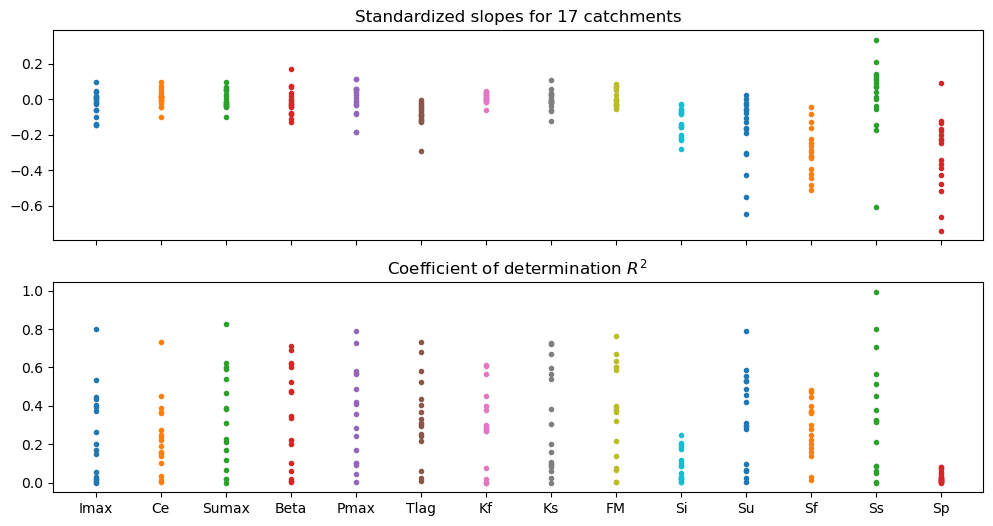

In [146]:
fig, axs = plt.subplots(2,1, figsize=(12,6), sharey=False, sharex=True)
ax = axs[0]
for i, col in enumerate(df_r2.columns): 
    vals = df_m_std[[col]].values.flatten()
    ax.plot([col]*len(vals),vals,marker=".",lw=0)
    
ax.set_title("Standardized slopes for 17 catchments");

ax = axs[1]
for i, col in enumerate(df_r2.columns): 
    vals = df_r2[[col]].values.flatten()
    ax.plot([col]*len(vals),vals,marker=".",lw=0)
    
ax.set_title("Coefficient of determination $R^2$ ");

fig.savefig(figure_path / (f"Standardized_slopes_and_R2_for_17_catchments.png"), bbox_inches="tight",dpi=100)

In [10]:
# for i in range(len(lst_ds)):
#     fig, ax = plt.subplots(1,1,figsize=(12,5))
#     plot_hydrograph(lst_ds[i], ax)
#     ax.legend()

In [11]:
len(lst_ds)

17

# individual:

## 0

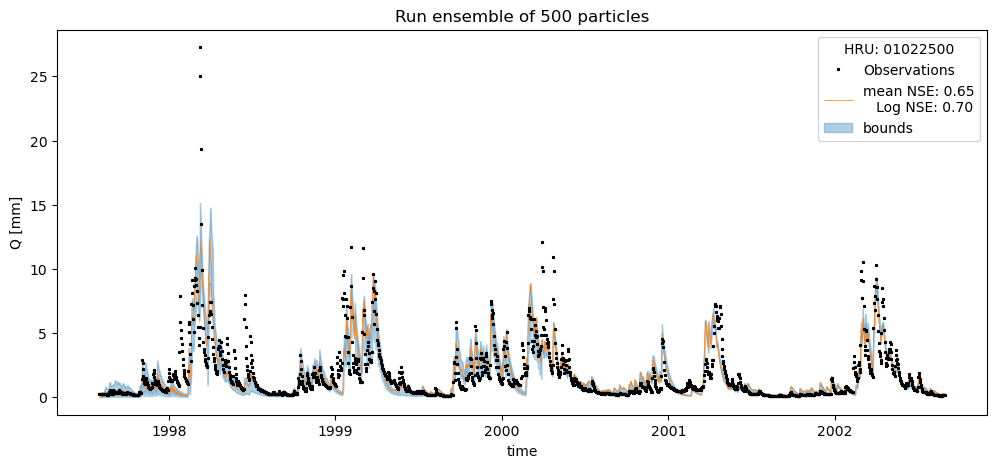

In [45]:
i=0
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")

In [15]:
j=2
parameter = param_names[j]
x = range(len(ds_combined.time))
result = scipy.stats.linregress(x, ds_combined[parameter].sel(summary_stat='mean').to_numpy())
result

LinregressResult(slope=0.053653964533736165, intercept=230.05865575120734, rvalue=0.7334497614468216, pvalue=2.52594757403e-313, stderr=0.0011545284963544334, intercept_stderr=1.237315610232864)

$y = mx + c$
$m = y-c/x [y/x]$

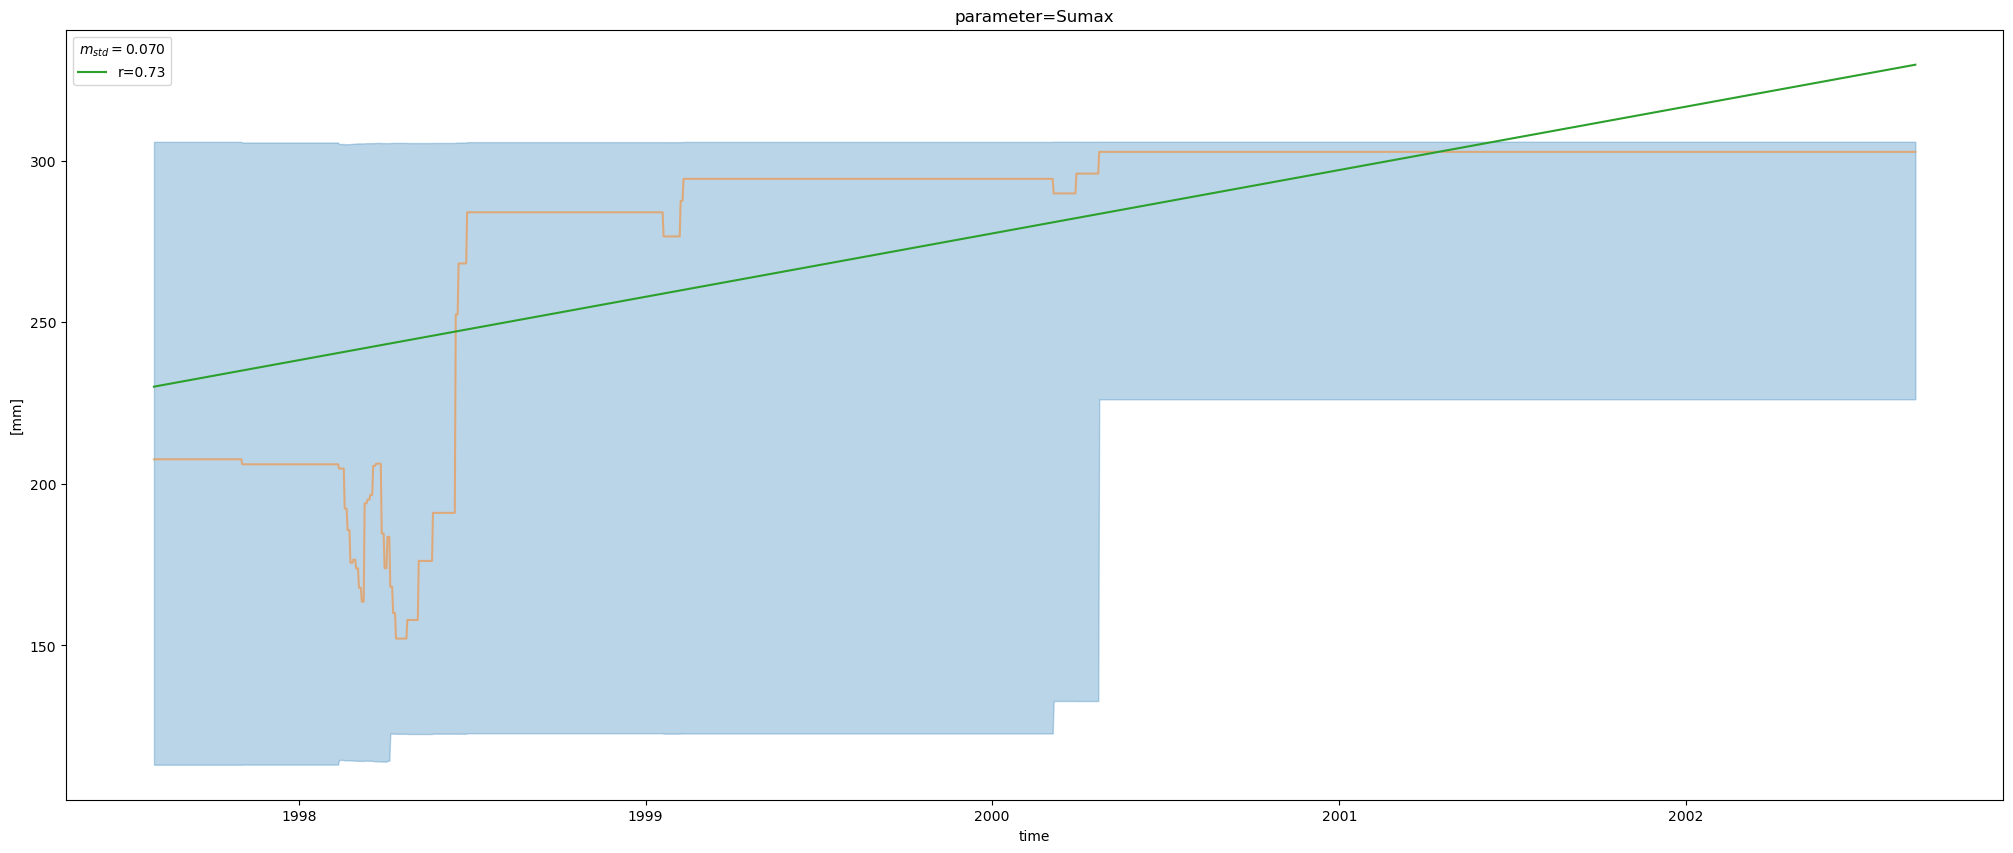

In [16]:
fig, ax = plt.subplots(1,1,figsize=(25,10),sharex=True)

n_particles = ds_combined.attrs['n_particles']
ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
ax.fill_between(ds_combined.time, 
                 ds_combined[parameter].sel(summary_stat="min").values,
                 ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
ax.set_ylabel(f'[{units[param_names[j]]}]')


# y = mx + c
# m = (y-c)/x
y = result.slope * x + result.intercept
ax.plot(ds_combined.time, y, color="C2",label=f"r={result.rvalue:.2f}")
slope_text = '$m_{std}=$'
ax.legend(title=f'{slope_text}{result.slope*365/y.mean():.3f}')

In [17]:
y.mean()

279.8495348385145

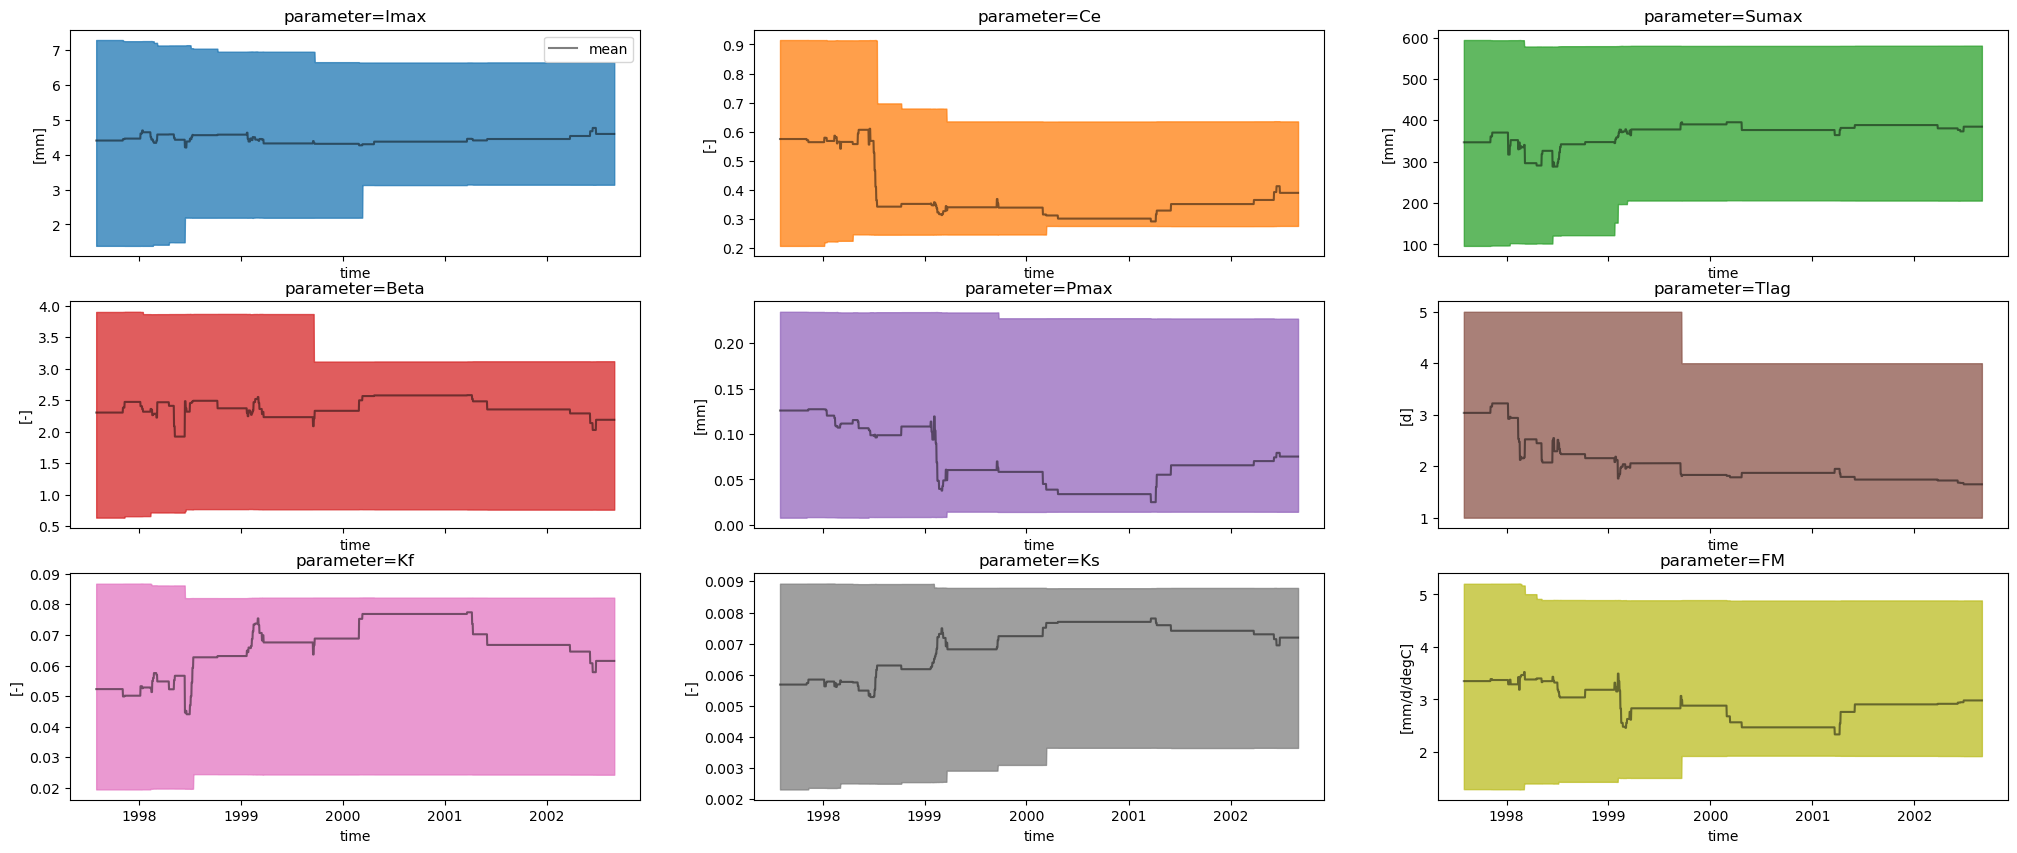

In [58]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
plot_params(ds_combined, param_names,  axs)
# fig.savefig(figure_path / (f"{ds_combined.attrs['HRU_id']}" + '_parameters.png'), bbox_inches="tight",dpi=400)

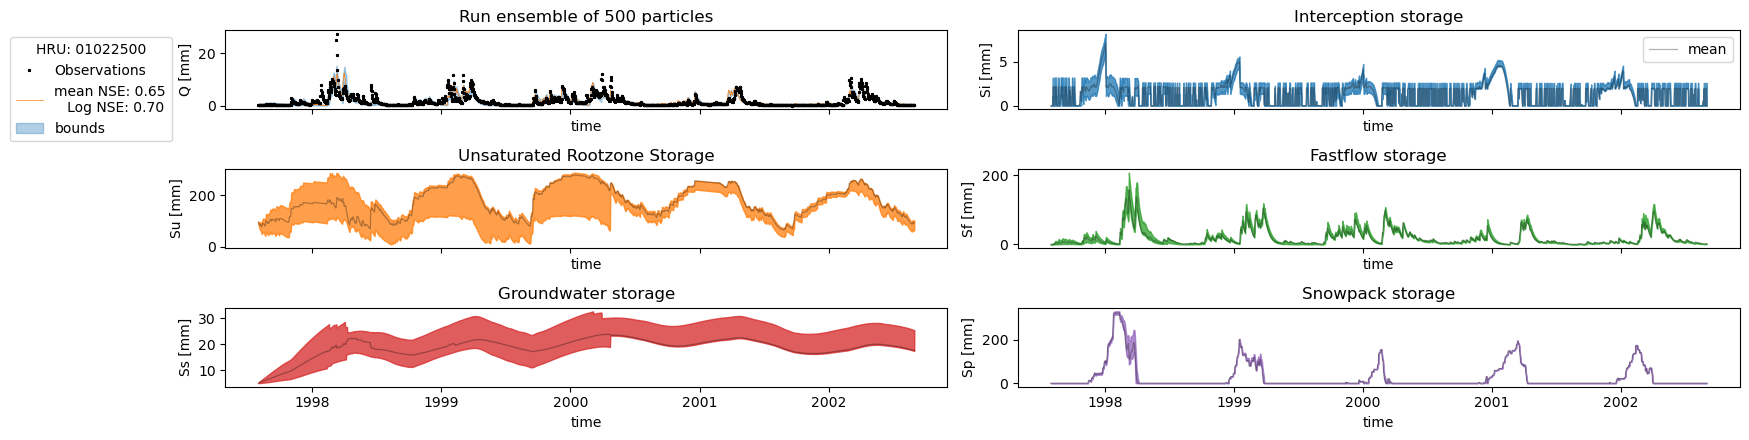

In [42]:
n=3
fig, axs = plt.subplots(n,2,figsize=(16,n*1.5),sharex=True)
ax = axs.flatten()
plot_variable(ds_combined, stor_names, ax)
fig.tight_layout()
ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}",bbox_to_anchor=(-0.065,1))
fig.savefig(figure_path / (f"{ds_combined.attrs['HRU_id']}" + '_storages.png'), bbox_inches="tight",dpi=400)

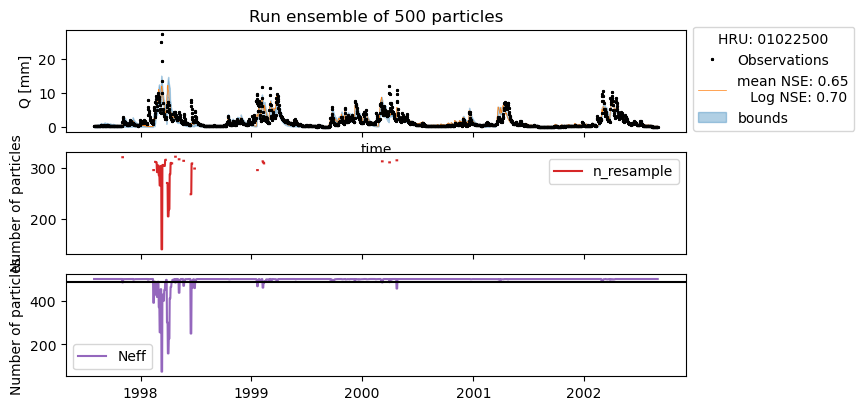

In [20]:
fig, ax = plt.subplots(3,1, figsize=(8,4.5),sharex=True)
ax[0] = plot_hydrograph(ds_combined, ax[0])
ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}",bbox_to_anchor=(1.,1.1))
for j, val in enumerate(['n_resample','Neff']):
    ax[j+1].plot(ds_combined['time'].values, ds_combined[val].values,color=f"C{j+3}",label=val)
    ax[j+1].legend()
    ax[j+1].set_ylabel('Number of particles')
ax[2].axhline(ds_combined.attrs['n_particles']*0.975, color='k');

## 1

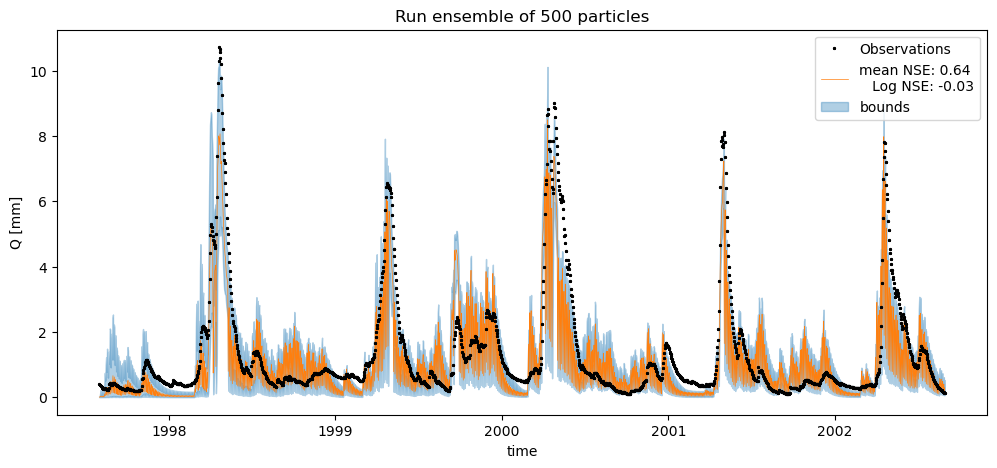

In [59]:
i=1
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

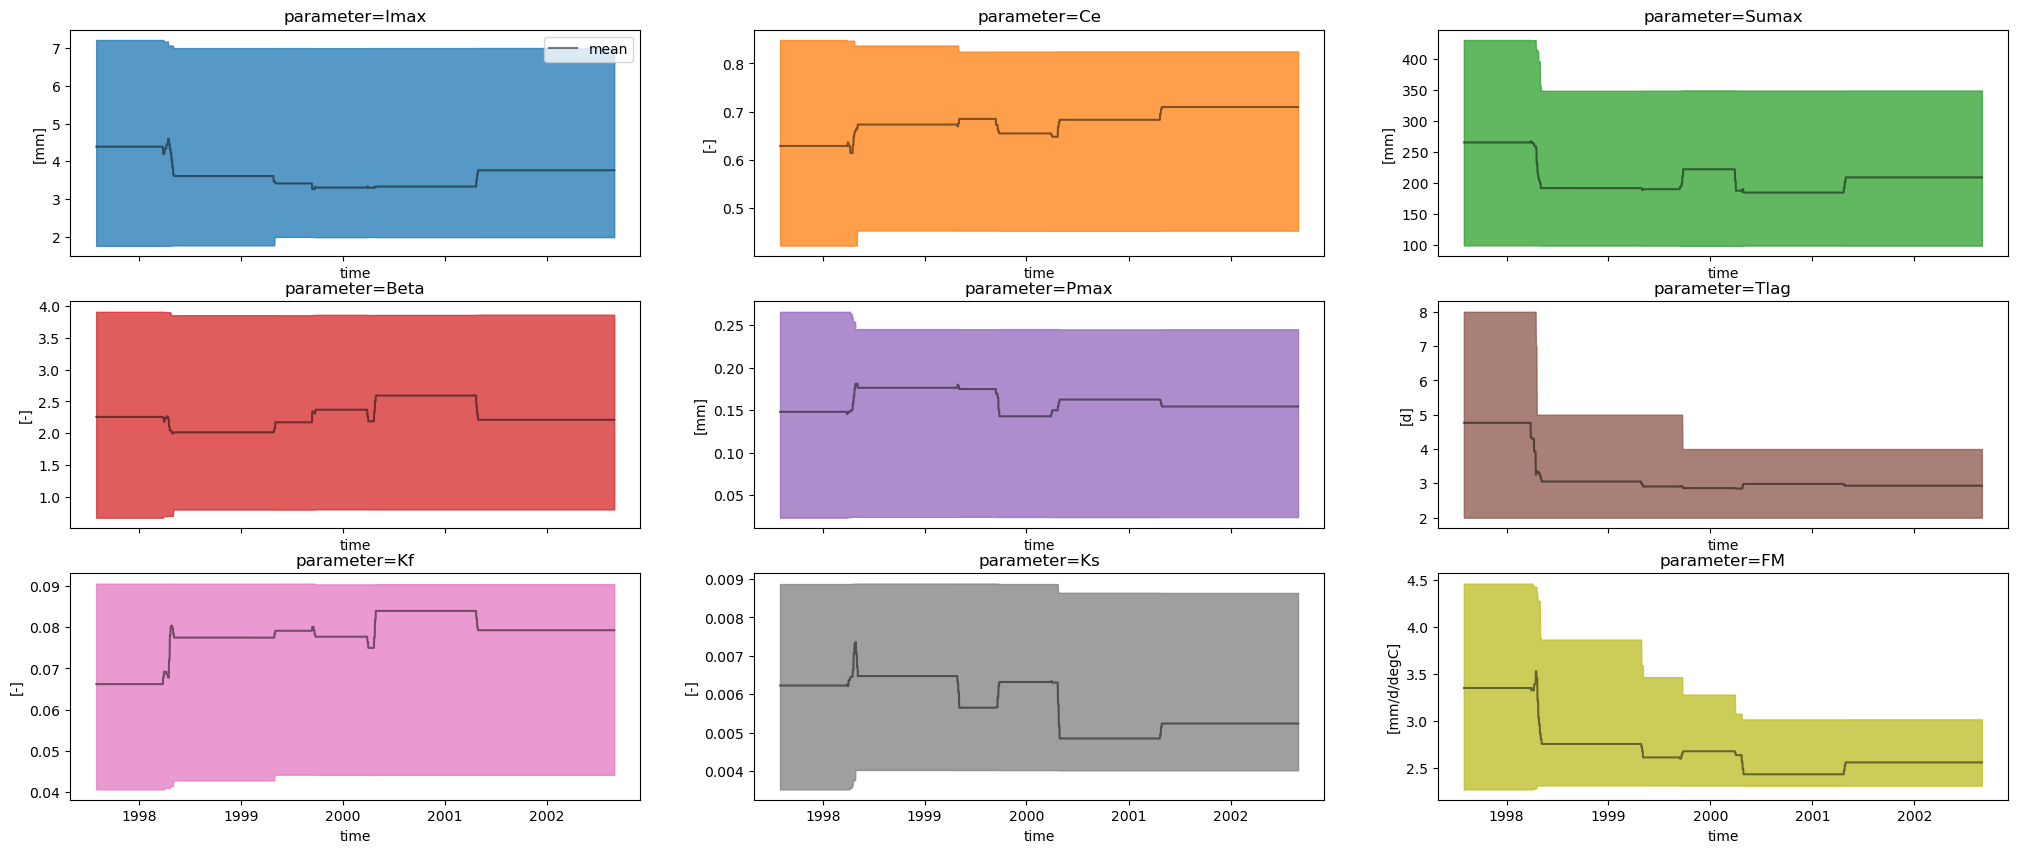

In [60]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
plot_params(ds_combined, param_names,  axs)

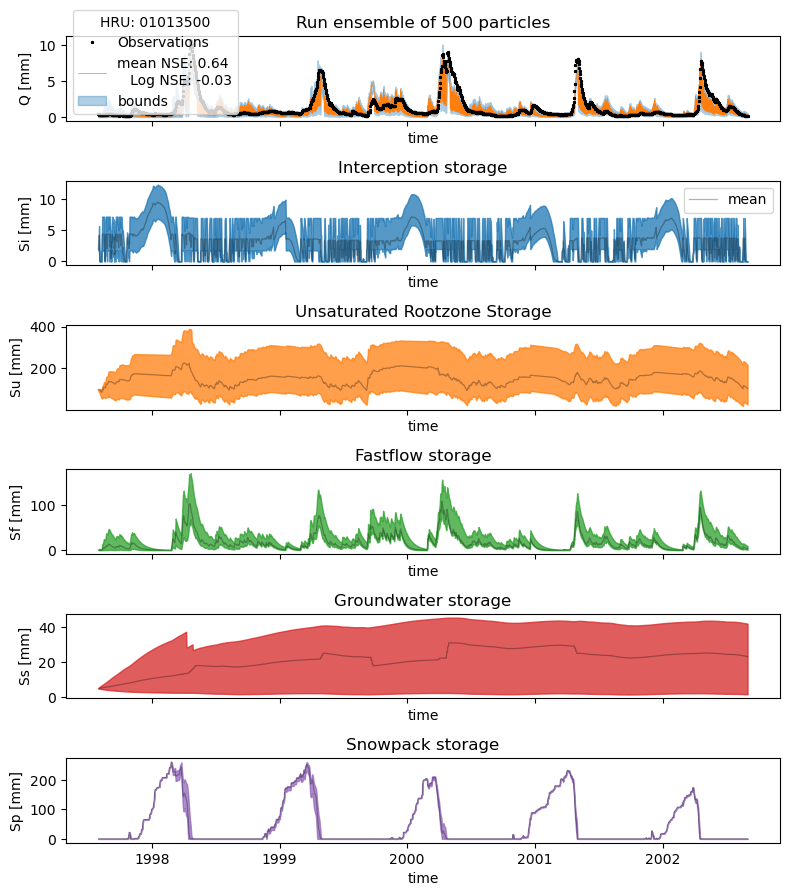

In [63]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

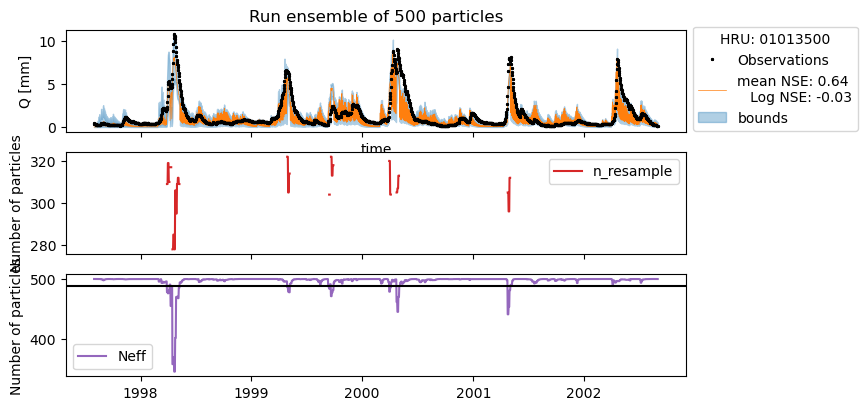

In [64]:
fig, ax = plt.subplots(3,1, figsize=(8,4.5),sharex=True)
ax[0] = plot_hydrograph(ds_combined, ax[0])
ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}",bbox_to_anchor=(1.,1.1))
for j, val in enumerate(['n_resample','Neff']):
    ax[j+1].plot(ds_combined['time'].values, ds_combined[val].values,color=f"C{j+3}",label=val)
    ax[j+1].legend()
    ax[j+1].set_ylabel('Number of particles')
ax[2].axhline(ds_combined.attrs['n_particles']*0.975, color='k');

## 2 

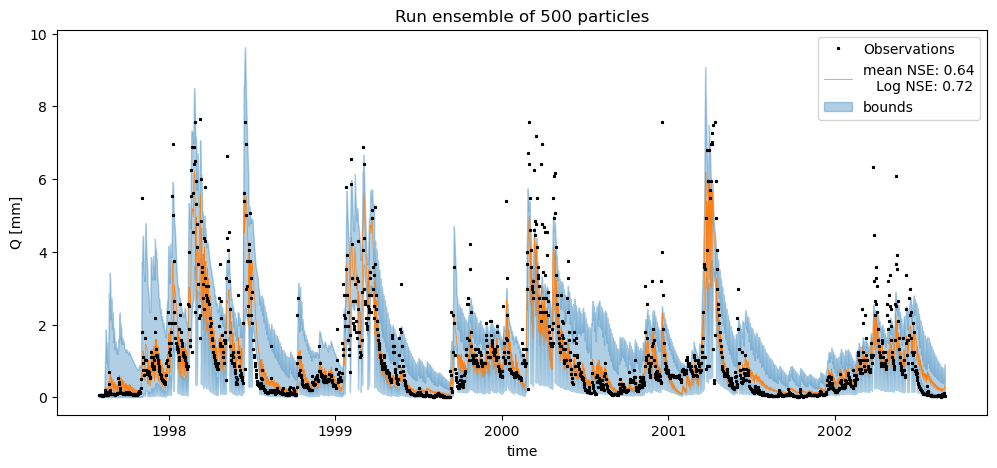

In [89]:
i=2
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

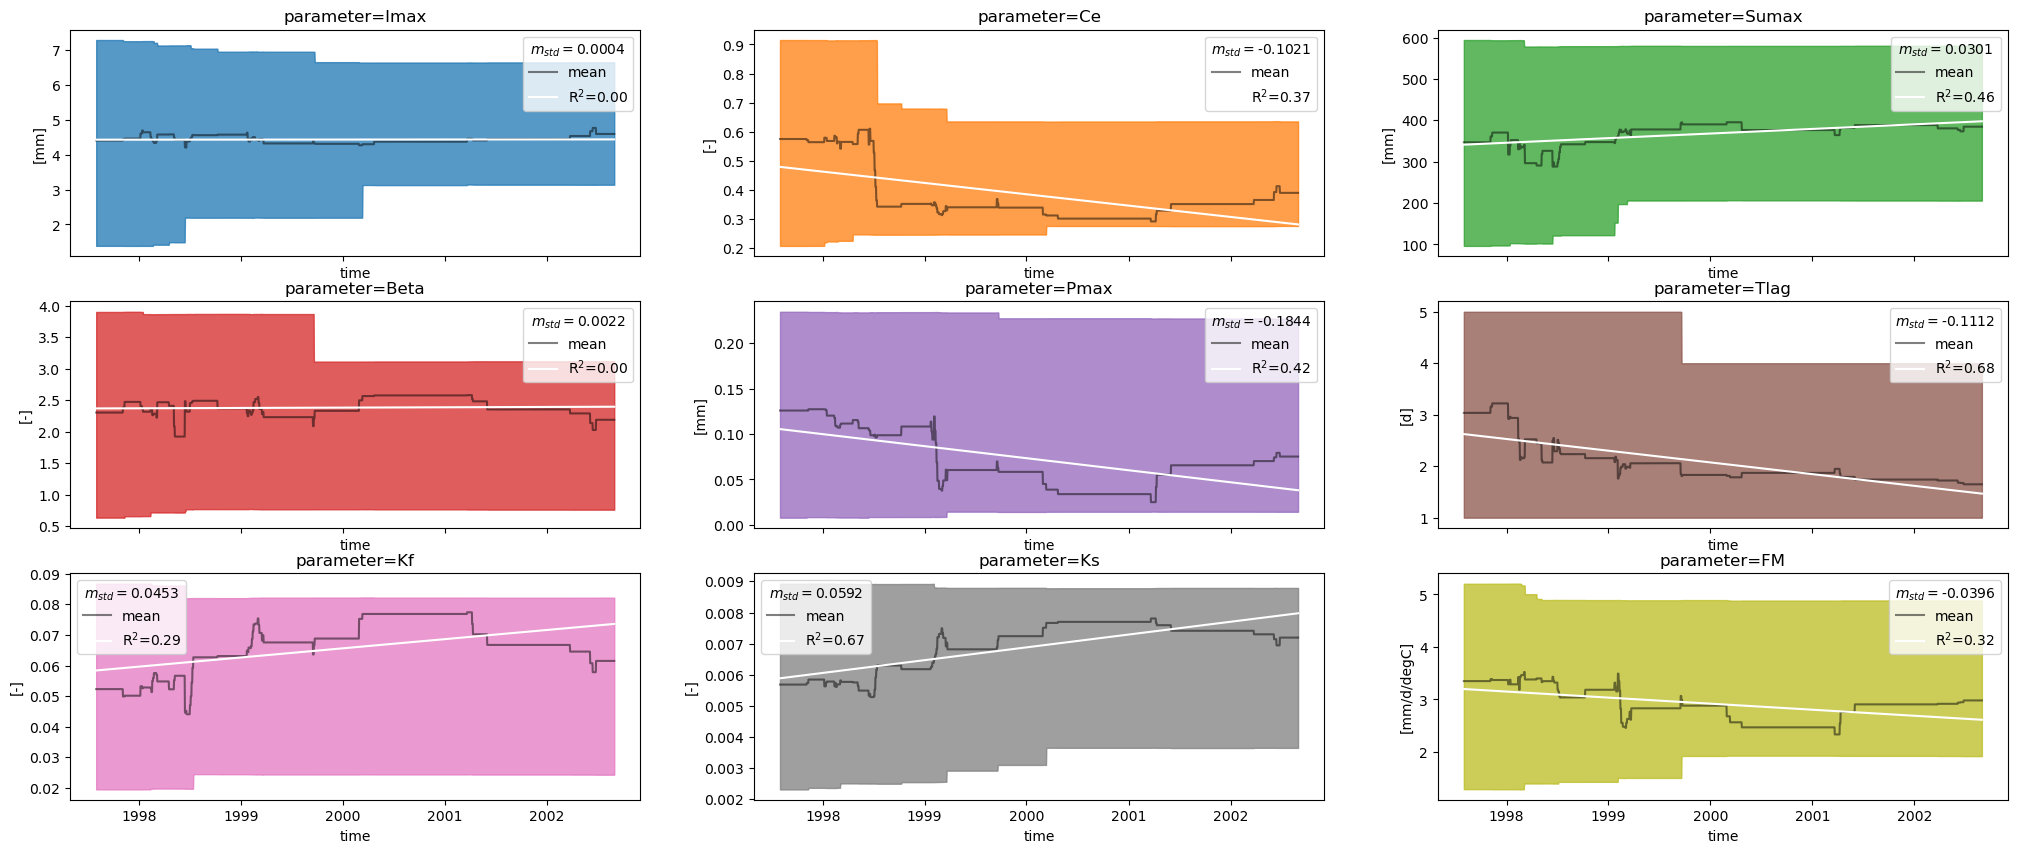

In [93]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
plot_params(ds_combined, param_names,  axs, True)
fig.savefig(figure_path / (f"{ds_combined.attrs['HRU_id']}" + '_parameters.png'), bbox_inches="tight",dpi=100)

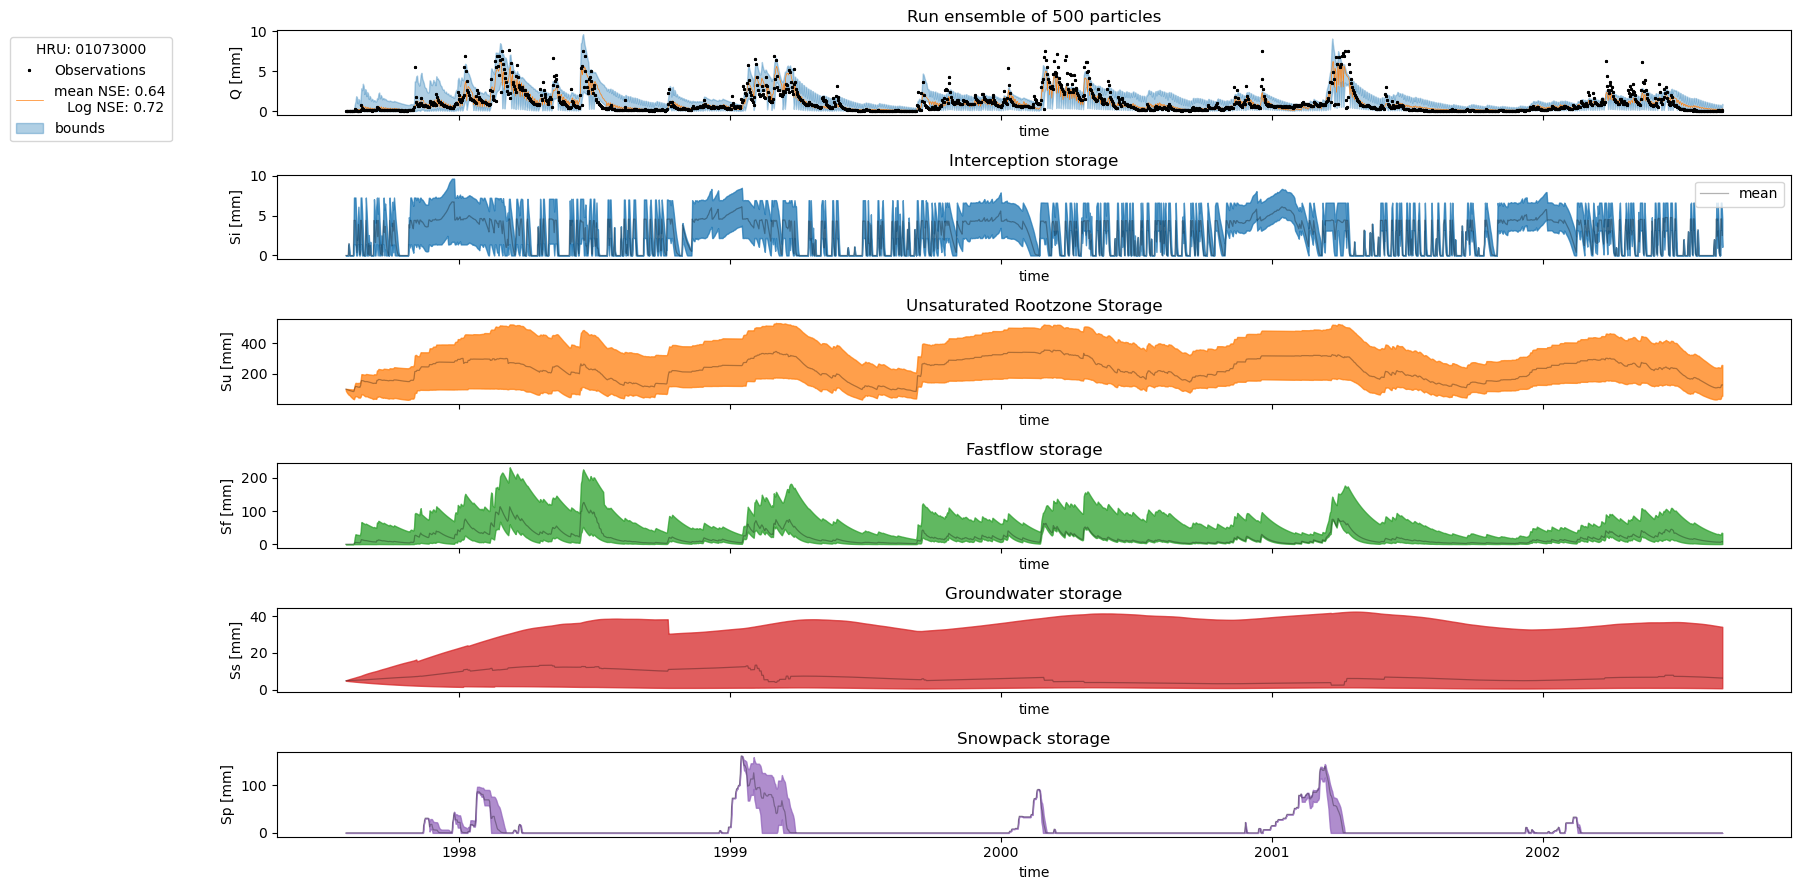

In [91]:
n=6
fig, axs = plt.subplots(n,1,figsize=(16,n*1.5),sharex=True)
ax = axs.flatten()
plot_variable(ds_combined, stor_names, ax)
fig.tight_layout()
ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}",bbox_to_anchor=(-0.065,1))
# fig.savefig(figure_path / (f"{ds_combined.attrs['HRU_id']}" + '_storages.png'), bbox_inches="tight",dpi=100)

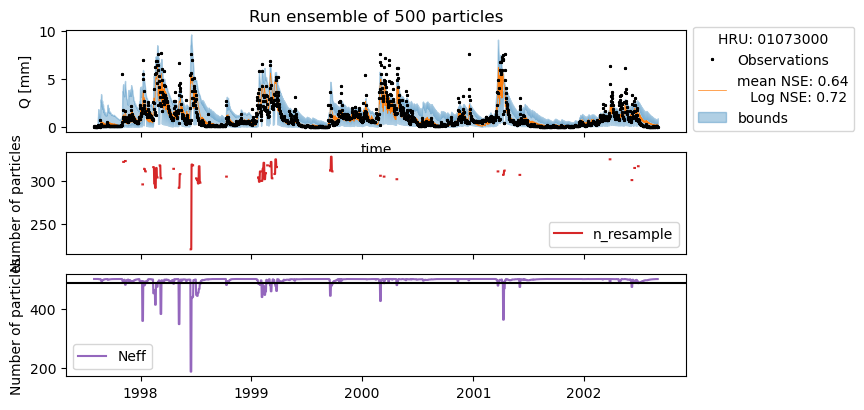

In [92]:
fig, ax = plt.subplots(3,1, figsize=(8,4.5),sharex=True)
ax[0] = plot_hydrograph(ds_combined, ax[0])
ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}",bbox_to_anchor=(1.,1.1))
for j, val in enumerate(['n_resample','Neff']):
    ax[j+1].plot(ds_combined['time'].values, ds_combined[val].values,color=f"C{j+3}",label=val)
    ax[j+1].legend()
    ax[j+1].set_ylabel('Number of particles')
ax[2].axhline(ds_combined.attrs['n_particles']*0.975, color='k');

## 3

In [ ]:
i=3
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

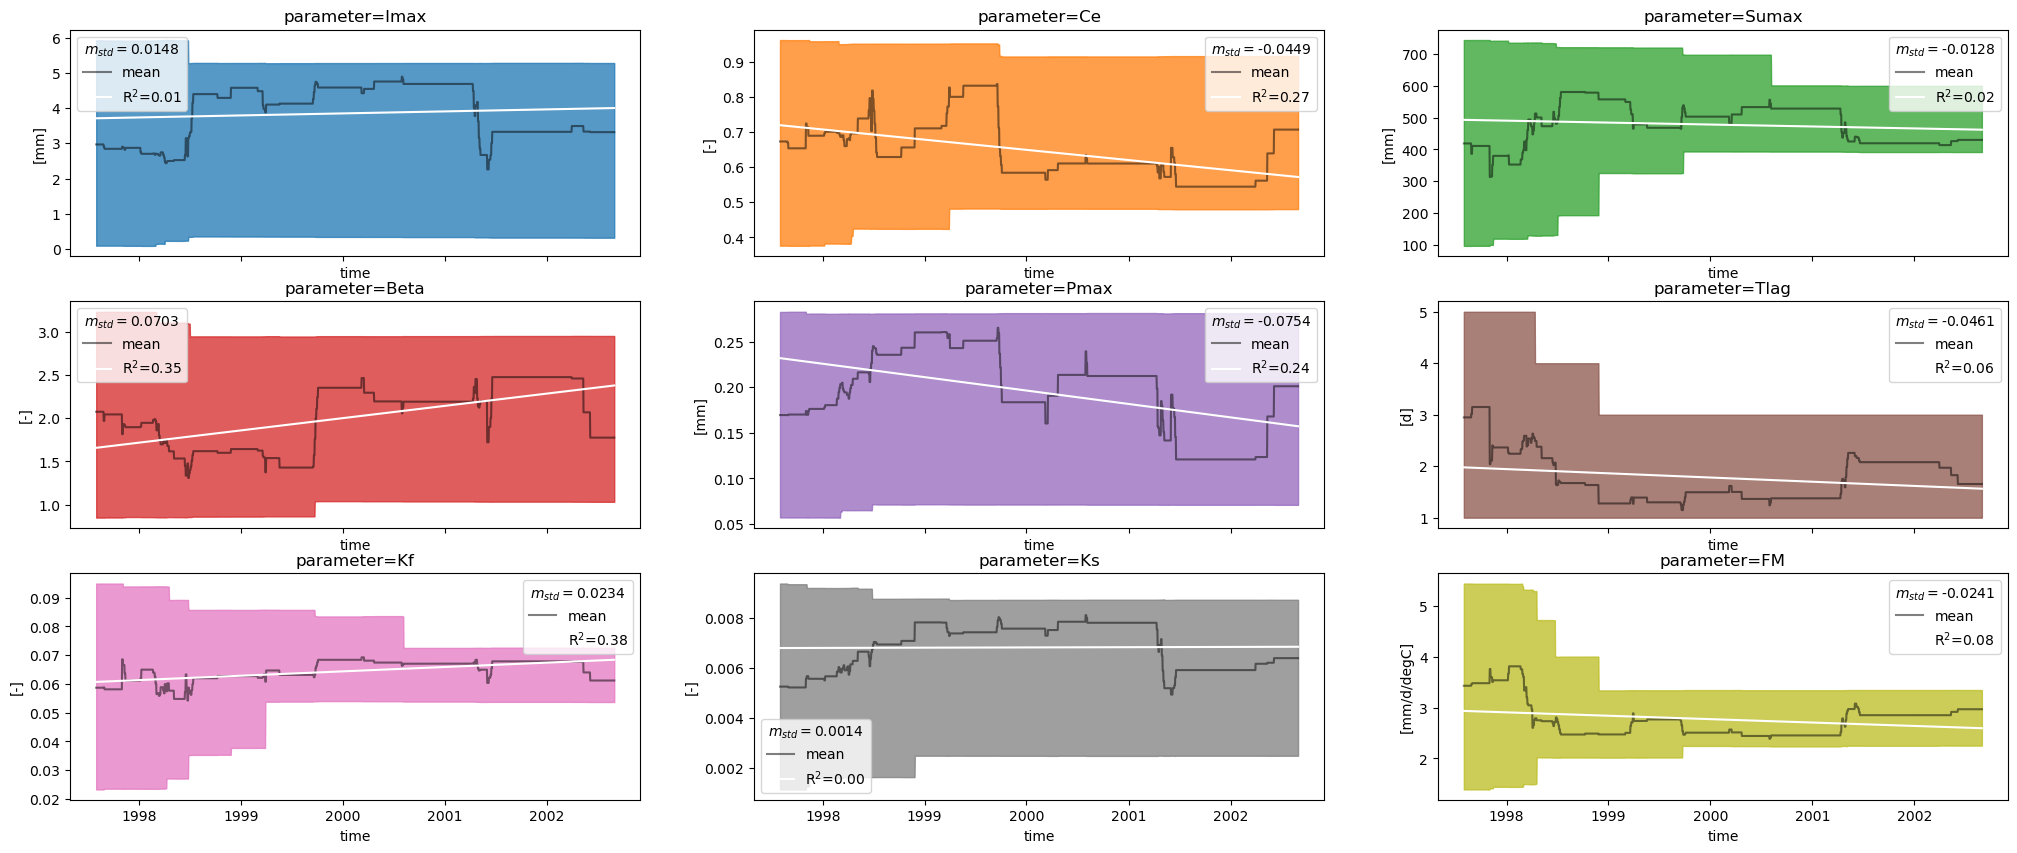

In [85]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
plot_params(ds_combined, param_names,  axs, True)

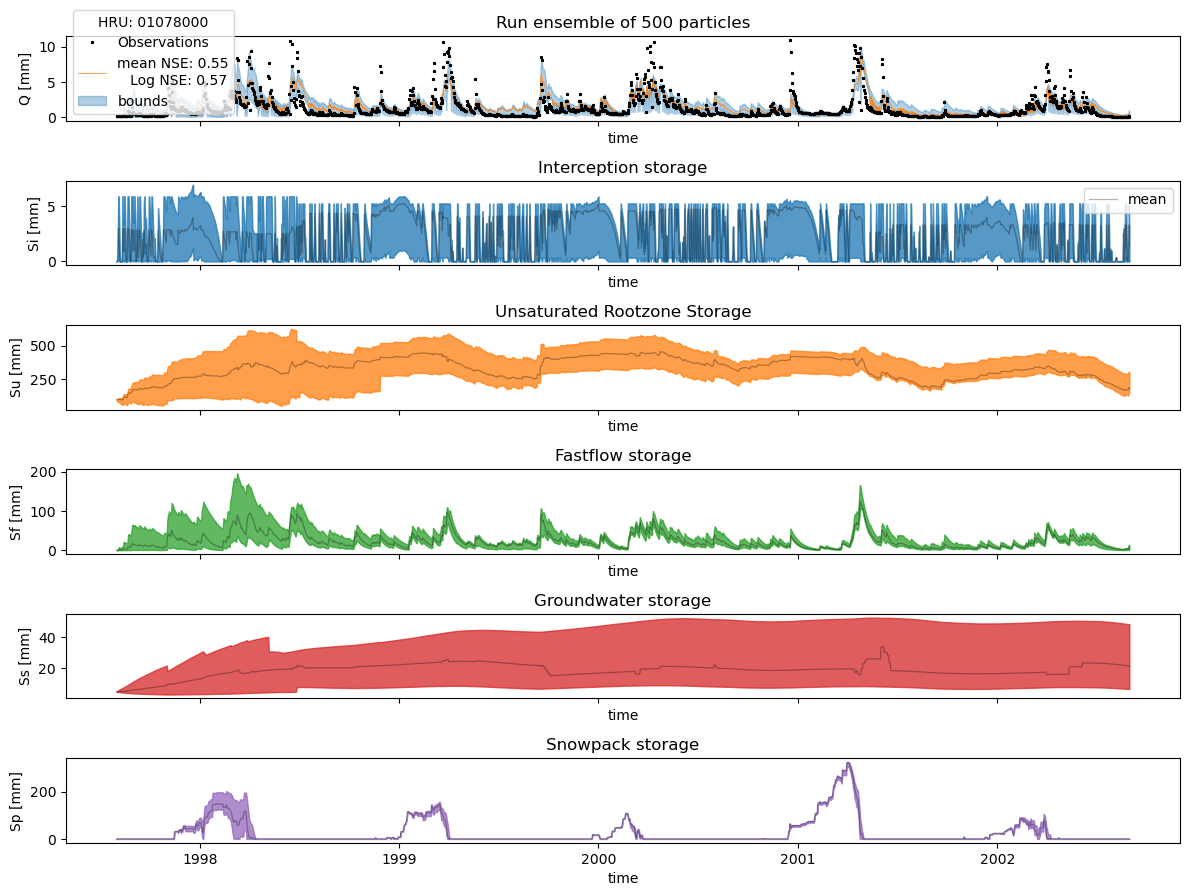

In [82]:
n=6
fig, axs = plt.subplots(n,1,figsize=(12,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

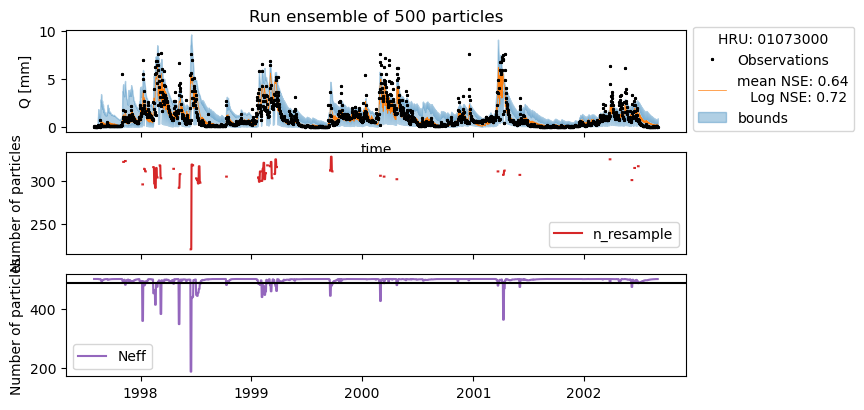

In [71]:
fig, ax = plt.subplots(3,1, figsize=(8,4.5),sharex=True)
ax[0] = plot_hydrograph(ds_combined, ax[0])
ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}",bbox_to_anchor=(1.,1.1))
for j, val in enumerate(['n_resample','Neff']):
    ax[j+1].plot(ds_combined['time'].values, ds_combined[val].values,color=f"C{j+3}",label=val)
    ax[j+1].legend()
    ax[j+1].set_ylabel('Number of particles')
ax[2].axhline(ds_combined.attrs['n_particles']*0.975, color='k');

## 4

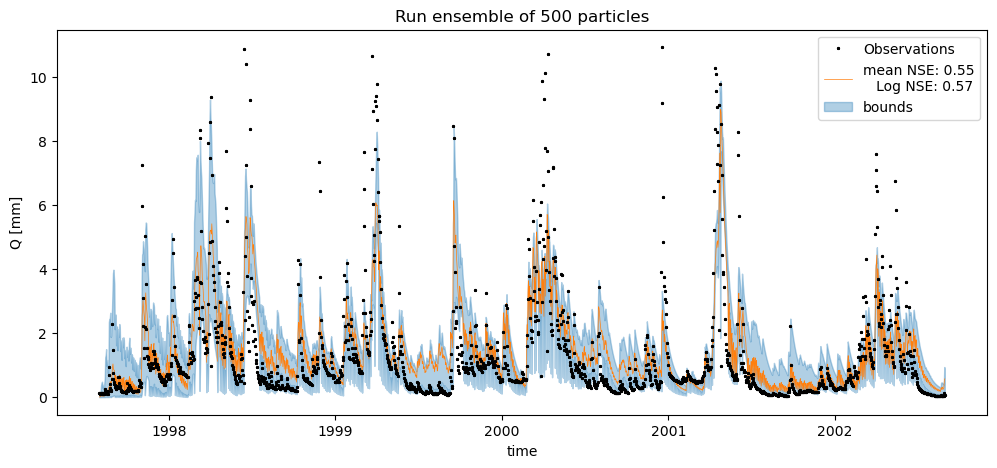

In [73]:
i=4
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

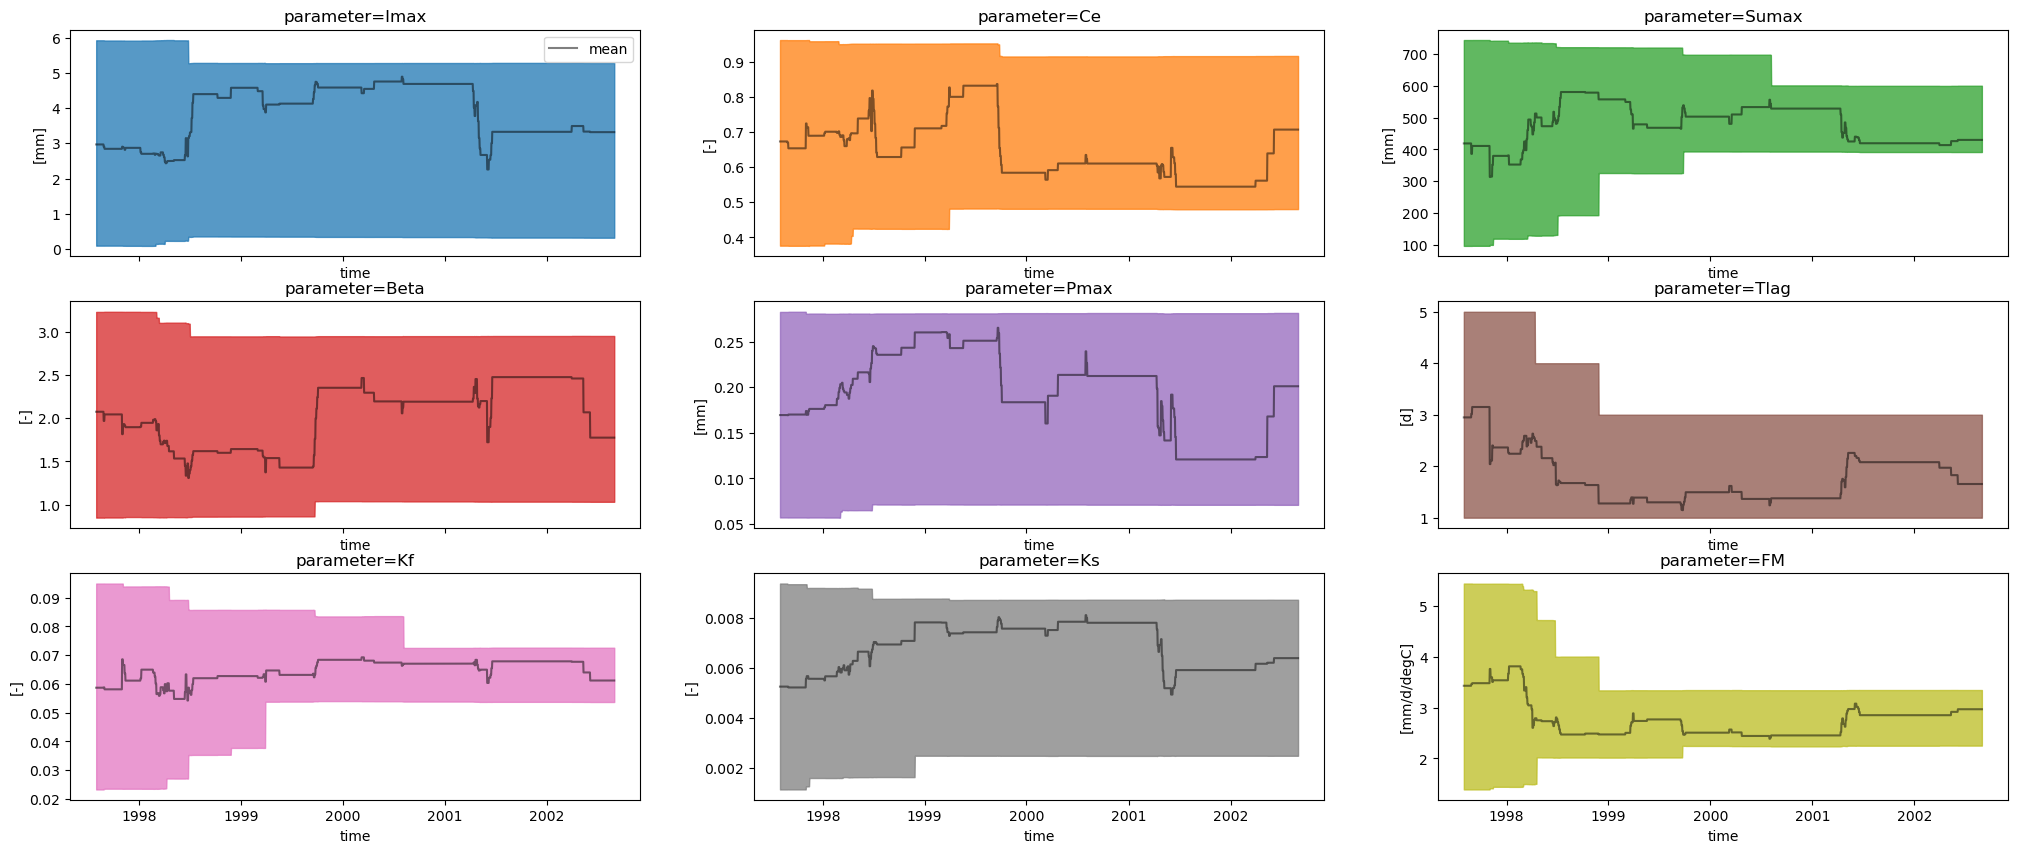

In [74]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
plot_params(ds_combined, param_names,  axs)

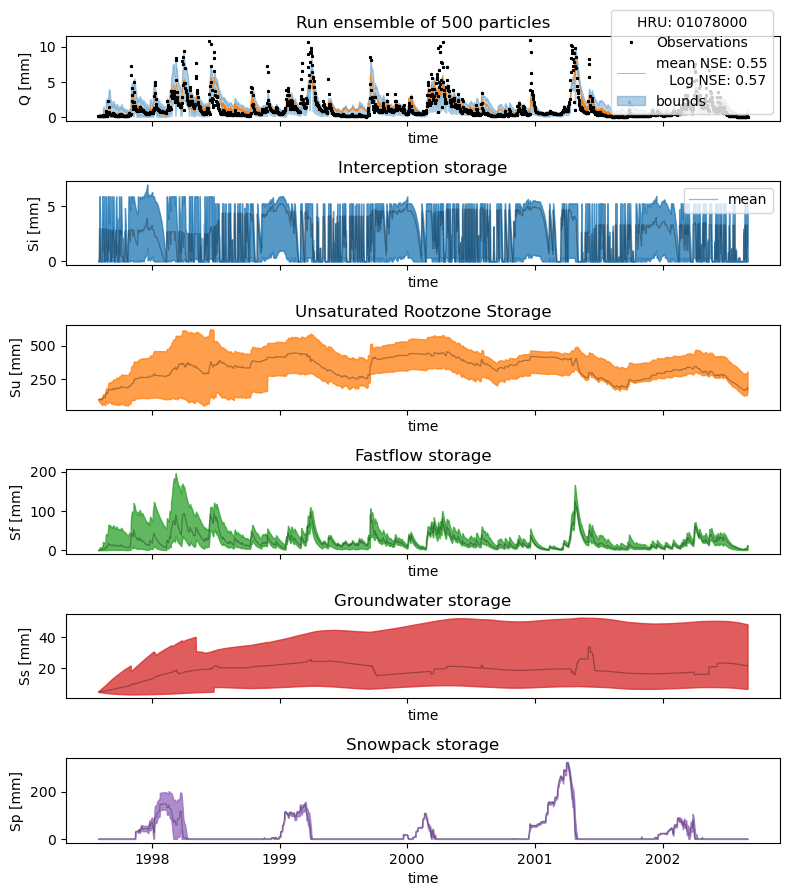

In [75]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

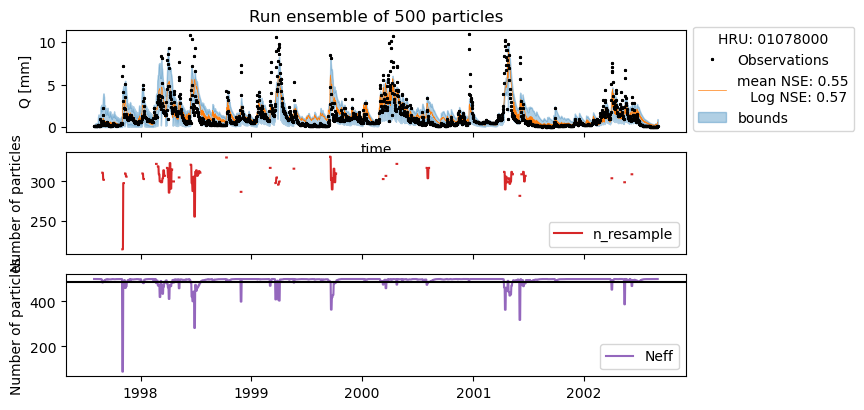

In [76]:
fig, ax = plt.subplots(3,1, figsize=(8,4.5),sharex=True)
ax[0] = plot_hydrograph(ds_combined, ax[0])
ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}",bbox_to_anchor=(1.,1.1))
for j, val in enumerate(['n_resample','Neff']):
    ax[j+1].plot(ds_combined['time'].values, ds_combined[val].values,color=f"C{j+3}",label=val)
    ax[j+1].legend()
    ax[j+1].set_ylabel('Number of particles')
ax[2].axhline(ds_combined.attrs['n_particles']*0.975, color='k');

## 5

In [ ]:
i=5
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

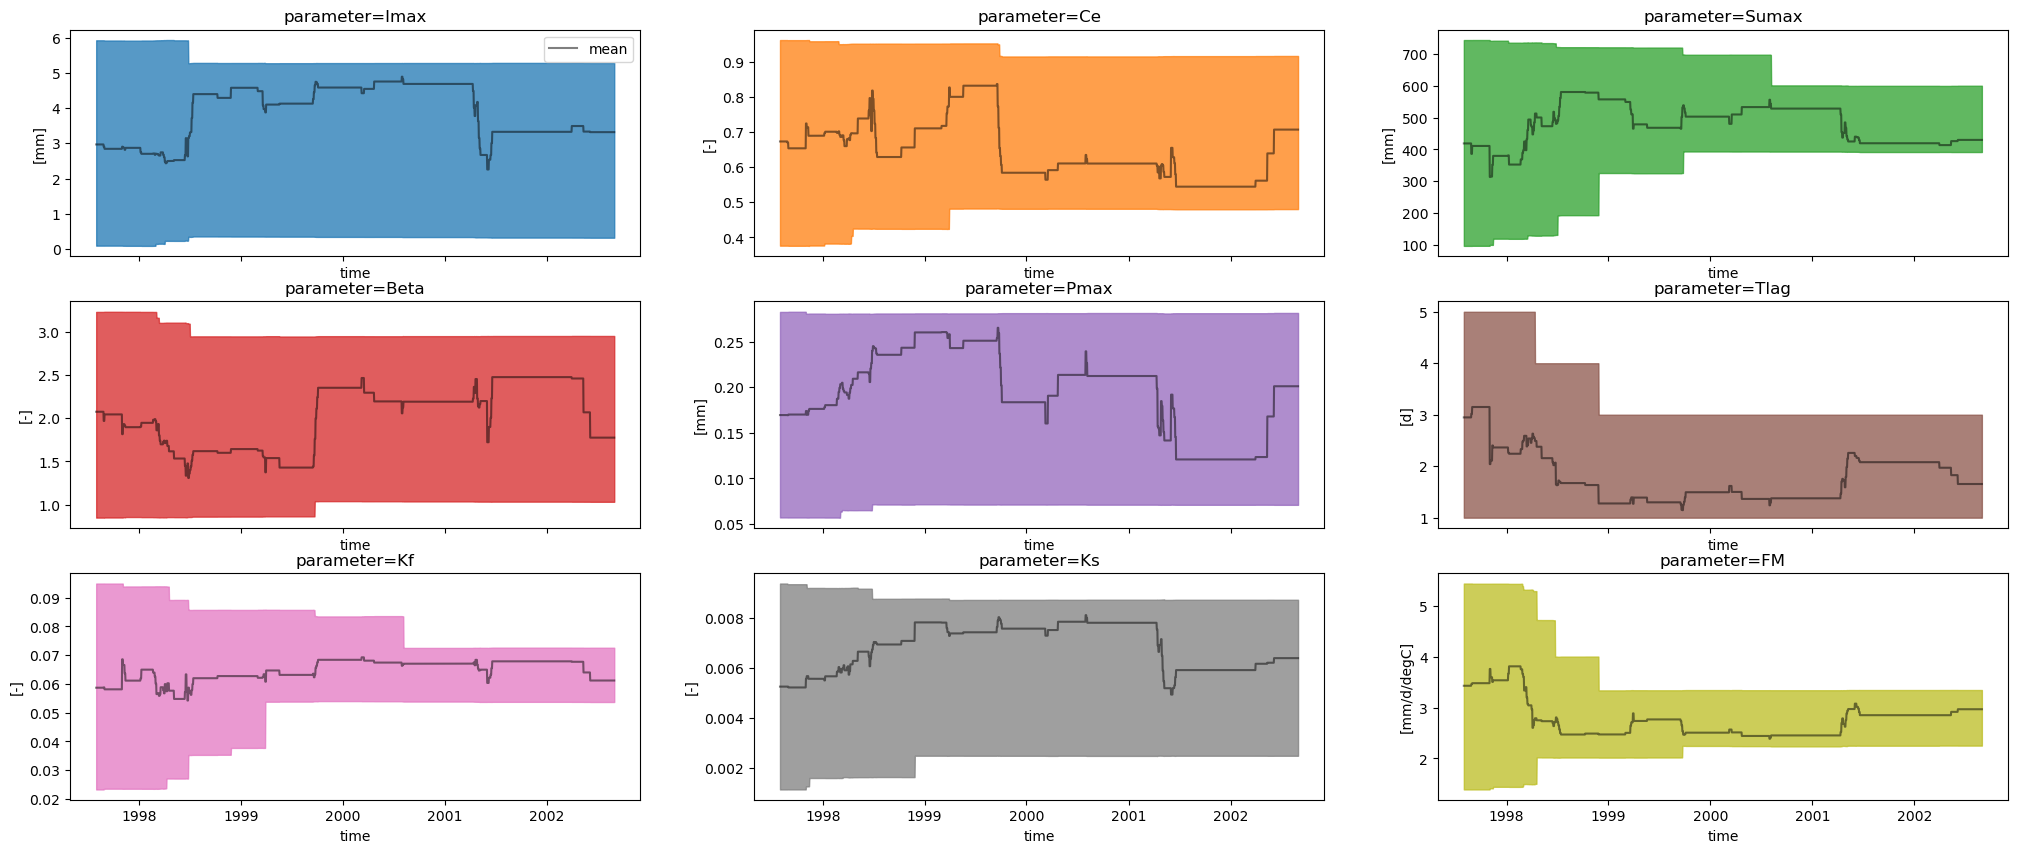

In [77]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
plot_params(ds_combined, param_names,  axs)

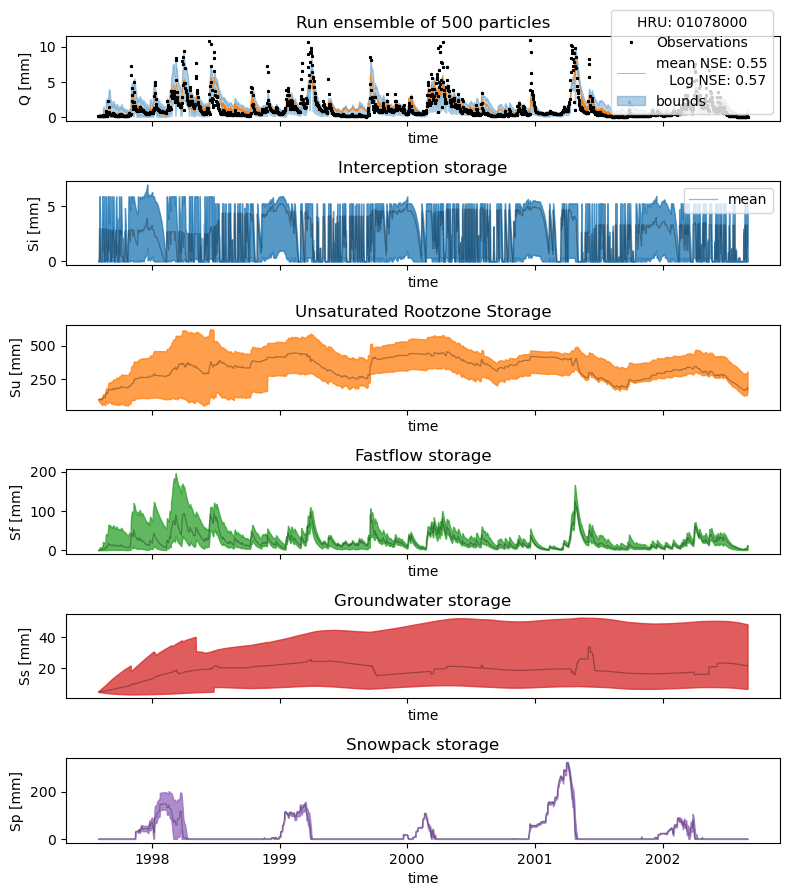

In [78]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

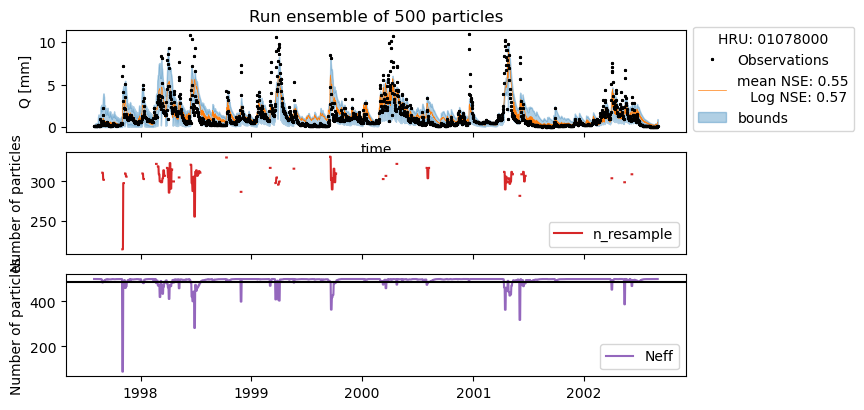

In [79]:
fig, ax = plt.subplots(3,1, figsize=(8,4.5),sharex=True)
ax[0] = plot_hydrograph(ds_combined, ax[0])
ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}",bbox_to_anchor=(1.,1.1))
for j, val in enumerate(['n_resample','Neff']):
    ax[j+1].plot(ds_combined['time'].values, ds_combined[val].values,color=f"C{j+3}",label=val)
    ax[j+1].legend()
    ax[j+1].set_ylabel('Number of particles')
ax[2].axhline(ds_combined.attrs['n_particles']*0.975, color='k');

## 6

In [ ]:
i=6
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']
    ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
    ax.fill_between(ds_combined.time, 
                     ds_combined[parameter].sel(summary_stat="min").values,
                     ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

In [ ]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

## 7

In [ ]:
i=7
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']
    ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
    ax.fill_between(ds_combined.time, 
                     ds_combined[parameter].sel(summary_stat="min").values,
                     ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

In [ ]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(8,4.5),sharex=True)
ax[0] = plot_hydrograph(ds_combined, ax[0])
ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}",bbox_to_anchor=(1.,1.1))
for j, val in enumerate(['n_resample','Neff']):
    ax[j+1].plot(ds_combined['time'].values, ds_combined[val].values,color=f"C{j+3}",label=val)
    ax[j+1].legend()
    ax[j+1].set_ylabel('Number of particles')
ax[2].axhline(ds_combined.attrs['n_particles']*0.975, color='k');

## 8

In [ ]:
i=8
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']

    ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
    ax.fill_between(ds_combined.time, 
                     ds_combined[parameter].sel(summary_stat="min").values,
                     ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

In [ ]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(8,4.5),sharex=True)
ax[0] = plot_hydrograph(ds_combined, ax[0])
ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}",bbox_to_anchor=(1.,1.1))
for j, val in enumerate(['n_resample','Neff']):
    ax[j+1].plot(ds_combined['time'].values, ds_combined[val].values,color=f"C{j+3}",label=val)
    ax[j+1].legend()
    ax[j+1].set_ylabel('Number of particles')
ax[2].axhline(ds_combined.attrs['n_particles']*0.975, color='k');

## 9

In [ ]:
i=9
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']

    ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
    ax.fill_between(ds_combined.time, 
                     ds_combined[parameter].sel(summary_stat="min").values,
                     ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

In [ ]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(8,4.5),sharex=True)
ax[0] = plot_hydrograph(ds_combined, ax[0])
ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}",bbox_to_anchor=(1.,1.1))
for j, val in enumerate(['n_resample','Neff']):
    ax[j+1].plot(ds_combined['time'].values, ds_combined[val].values,color=f"C{j+3}",label=val)
    ax[j+1].legend()
    ax[j+1].set_ylabel('Number of particles')
ax[2].axhline(ds_combined.attrs['n_particles']*0.975, color='k');

## 10

In [ ]:
i=10
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']

    ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
    ax.fill_between(ds_combined.time, 
                     ds_combined[parameter].sel(summary_stat="min").values,
                     ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

In [ ]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(8,4.5),sharex=True)
ax[0] = plot_hydrograph(ds_combined, ax[0])
ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}",bbox_to_anchor=(1.,1.1))
for j, val in enumerate(['n_resample','Neff']):
    ax[j+1].plot(ds_combined['time'].values, ds_combined[val].values,color=f"C{j+3}",label=val)
    ax[j+1].legend()
    ax[j+1].set_ylabel('Number of particles')
ax[2].axhline(ds_combined.attrs['n_particles']*0.975, color='k');

## 11

In [ ]:
i=11
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']

    ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
    ax.fill_between(ds_combined.time, 
                     ds_combined[parameter].sel(summary_stat="min").values,
                     ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

In [ ]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(8,4.5),sharex=True)
ax[0] = plot_hydrograph(ds_combined, ax[0])
ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}",bbox_to_anchor=(1.,1.1))
for j, val in enumerate(['n_resample','Neff']):
    ax[j+1].plot(ds_combined['time'].values, ds_combined[val].values,color=f"C{j+3}",label=val)
    ax[j+1].legend()
    ax[j+1].set_ylabel('Number of particles')
ax[2].axhline(ds_combined.attrs['n_particles']*0.975, color='k');

## 12

In [ ]:
i=12
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']

    ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
    ax.fill_between(ds_combined.time, 
                     ds_combined[parameter].sel(summary_stat="min").values,
                     ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

In [ ]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(8,4.5),sharex=True)
ax[0] = plot_hydrograph(ds_combined, ax[0])
ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}",bbox_to_anchor=(1.,1.1))
for j, val in enumerate(['n_resample','Neff']):
    ax[j+1].plot(ds_combined['time'].values, ds_combined[val].values,color=f"C{j+3}",label=val)
    ax[j+1].legend()
    ax[j+1].set_ylabel('Number of particles')
ax[2].axhline(ds_combined.attrs['n_particles']*0.975, color='k');

## 13

In [ ]:
i=13
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']

    ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
    ax.fill_between(ds_combined.time, 
                     ds_combined[parameter].sel(summary_stat="min").values,
                     ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

In [ ]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(8,4.5),sharex=True)
ax[0] = plot_hydrograph(ds_combined, ax[0])
ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}",bbox_to_anchor=(1.,1.1))
for j, val in enumerate(['n_resample','Neff']):
    ax[j+1].plot(ds_combined['time'].values, ds_combined[val].values,color=f"C{j+3}",label=val)
    ax[j+1].legend()
    ax[j+1].set_ylabel('Number of particles')
ax[2].axhline(ds_combined.attrs['n_particles']*0.975, color='k');

## 14

In [ ]:
i=14
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']

    ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
    ax.fill_between(ds_combined.time, 
                     ds_combined[parameter].sel(summary_stat="min").values,
                     ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

In [ ]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(8,4.5),sharex=True)
ax[0] = plot_hydrograph(ds_combined, ax[0])
ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}",bbox_to_anchor=(1.,1.1))
for j, val in enumerate(['n_resample','Neff']):
    ax[j+1].plot(ds_combined['time'].values, ds_combined[val].values,color=f"C{j+3}",label=val)
    ax[j+1].legend()
    ax[j+1].set_ylabel('Number of particles')
ax[2].axhline(ds_combined.attrs['n_particles']*0.975, color='k');

## 15

In [ ]:
i=15
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']

    ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
    ax.fill_between(ds_combined.time, 
                     ds_combined[parameter].sel(summary_stat="min").values,
                     ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

In [ ]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(8,4.5),sharex=True)
ax[0] = plot_hydrograph(ds_combined, ax[0])
ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}",bbox_to_anchor=(1.,1.1))
for j, val in enumerate(['n_resample','Neff']):
    ax[j+1].plot(ds_combined['time'].values, ds_combined[val].values,color=f"C{j+3}",label=val)
    ax[j+1].legend()
    ax[j+1].set_ylabel('Number of particles')
ax[2].axhline(ds_combined.attrs['n_particles']*0.975, color='k');

## 16

In [ ]:
i=16
ds_combined = lst_ds[i]
fig, ax = plt.subplots(1,1,figsize=(12,5))
plot_hydrograph(ds_combined, ax)
ax.legend()

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']

    ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
    ax.fill_between(ds_combined.time, 
                     ds_combined[parameter].sel(summary_stat="min").values,
                     ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

In [ ]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(8,4.5),sharex=True)
ax[0] = plot_hydrograph(ds_combined, ax[0])
ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}",bbox_to_anchor=(1.,1.1))
for j, val in enumerate(['n_resample','Neff']):
    ax[j+1].plot(ds_combined['time'].values, ds_combined[val].values,color=f"C{j+3}",label=val)
    ax[j+1].legend()
    ax[j+1].set_ylabel('Number of particles')
ax[2].axhline(ds_combined.attrs['n_particles']*0.975, color='k');